In [128]:
##import libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, confusion_matrix, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegressionCV

from sklearn.tree import export_graphviz
import graphviz

import warnings
warnings.filterwarnings("ignore")

In [97]:
##import data
train_data = pd.read_csv('Project2_Train.csv')
test_data = pd.read_csv('Project2_Test.csv')

In [98]:
##clean data and format into one hot encoding
def clean_data_OHE(df):
    x_data = df.iloc[:,1:8]
    y_data = df.iloc[:,8]

    x_data["Vehicle_Age"] = x_data["Vehicle_Age"].astype('category').cat.codes
    x_data = pd.get_dummies(x_data, columns=["Gender","Region_Code","Vehicle_Age","Vehicle_Damage"])
    x_data = x_data.rename(columns={'Vehicle_Age_0':'V_Age_1-2','Vehicle_Age_1':'V_Age_<1','Vehicle_Age_2':'V_Age_>2'})

    return x_data,y_data

In [99]:
##clean data and format into integer encoding
def clean_data_IE(df):
    x_data = df.iloc[:,1:8]
    y_data = df.iloc[:,8]

    lb_make = LabelEncoder()
    
    x_data["Gender"] = lb_make.fit_transform(x_data["Gender"])
    x_data["Region_Code"] = lb_make.fit_transform(x_data["Region_Code"])
    x_data["Vehicle_Age"] = lb_make.fit_transform(x_data["Vehicle_Age"])
    x_data["Vehicle_Damage"] = lb_make.fit_transform(x_data["Vehicle_Damage"])

    return x_data,y_data


In [100]:
##returns graph for ROC using fpr and tpr
def ROCgraph(fpr,tpr):
    
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic curve')
    plt.legend(loc="lower right")
    plt.show()
    
    return

In [101]:
##confusion matrix from proba and y_test values
def confusion_mat(proba,y_test):
    conf_mat = []
    thresh_list = [0.01, 0.1, 0.2, 0.5]

    for thresh in thresh_list:
        predicted = (proba >= thresh).astype('int')
        conf_mat.append(confusion_matrix(y_test, predicted) )  

    for i in range(0,4):
         print('Confusion Matrix at {0}%:'.format(int(thresh_list[i]*100)), '\n', conf_mat[i])
            
    return conf_mat

In [102]:
##benefits from confusion matrix
def benefit_st_old(conf_mat):
    thresh_list = [0.01, 0.1, 0.2, 0.5]
    
    bf_list = []
    for i in range(0,4):
        tn, fp, fn, tp = conf_mat[i].ravel()
        bf = tp*10 - fn*10 - fp*2 - (tp+fp)*1
        bf_list.append(bf)
        print('Benefit Structure at {0}:'.format(thresh_list[i]), bf)
    best_th = bf_list.index(max(bf_list))
    print('The best probability threshold is at ' + '\033[1m' + str(thresh_list[best_th]) + '\033[0m')

In [103]:
##benefits from confusion matrix
def benefit_st_new(conf_mat):
    thresh_list = [0.01, 0.1, 0.2, 0.5]
    
    bf_list = []
    for i in range(0,4):
        tn, fp, fn, tp = conf_mat[i].ravel()
        bf = tp*100 - fn*100 - fp*2 - (tp+fp)*1
        bf_list.append(bf)
        print('Benefit Structure at {0}:'.format(thresh_list[i]), bf)
    best_th = bf_list.index(max(bf_list))
    print('The best probability threshold is at ' + '\033[1m' + str(thresh_list[best_th]) + '\033[0m')

In [104]:
##returns ROC for logistics regression
def LR(data):

    X,Y = clean_data_OHE(data)

    lr = LogisticRegression()
    param_lr = {'C':[0.001, 0.01, 0.05, 0.1, 1, 100], 'max_iter': np.arange(50,100,1)}

    lr_clf = GridSearchCV(estimator=lr,
                         param_grid=param_lr,
                         scoring='roc_auc',
                         n_jobs =-1,
                          verbose = 0,
                         refit=True,
                         cv=5,
                         return_train_score=True)

    lr_result = lr_clf.fit(X,Y)

    best_params = lr_result.best_params_    
    print('Best Parameters for Logistic Regression: ', best_params)
    
    predictions_proba = lr_clf.best_estimator_.predict_proba(X)[:,1]
    auc = roc_auc_score(Y,predictions_proba)
    print( "AUC Score for Logistic Regression:", auc)

    fpr, tpr, thresholds = roc_curve(Y,predictions_proba)
    print(ROCgraph(fpr,tpr))
    
    coef = lr_clf.best_estimator_.coef_[0]
    col = list(X.columns)
    coefficient_df = pd.DataFrame({"Variable" : col, "Coefficient": coef})
    return coefficient_df   

In [121]:
##returns ROC for classification tree
def DT(data):

    X,Y = clean_data_IE(data)

    dt = DecisionTreeClassifier()
    param_dt = {'max_depth': [i for i in range(1,21,1)], 'min_samples_leaf': [1,2,3,4,5]}

    dt_clf = GridSearchCV(estimator=dt,
                         param_grid=param_dt,
                         scoring='roc_auc',
                         n_jobs =-1,
                          verbose = 0,
                         refit=True,
                         cv=5,
                         return_train_score=True)

    dt_result = dt_clf.fit(X,Y)

    best_params = dt_result.best_params_    
    print('Best Parameters for Decision Tree: ', best_params)
    
    predictions_proba = dt_clf.best_estimator_.predict_proba(X)[:,1]
    auc = roc_auc_score(Y,predictions_proba)
    print( "AUC Score for Decision Tree:", auc)

    fpr, tpr, thresholds = roc_curve(Y,predictions_proba)
    print(ROCgraph(fpr,tpr))
    
    feature_names = X.columns
    dot_data = export_graphviz(dt_clf.best_estimator_, out_file=None, 
                filled=True, rounded=True, feature_names=feature_names, class_names=['0','1','2'])
    
    graph = graphviz.Source(dot_data)
    
    
    return graph

In [106]:
##returns ROC for random forest
def RF(data):

    X,Y = clean_data_IE(data)

    rf = RandomForestClassifier()
    param_rf = {'max_depth': [i for i in range(1,21,1)], 'min_samples_leaf': [1,2,3,4,5]}

    rf_clf = GridSearchCV(estimator=rf,
                         param_grid=param_rf,
                         scoring='roc_auc',
                         n_jobs =-1,
                         refit=True,
                         cv=5,
                         return_train_score=True)

    rf_result = rf_clf.fit(X,Y)

    best_params = rf_result.best_params_    
    print('Best Parameters for Random Forest: ', best_params)
    
    predictions_proba = rf_clf.best_estimator_.predict_proba(X)[:,1]
    auc = roc_auc_score(Y,predictions_proba)
    print( "AUC Score for Random Forest:", auc)

    fpr, tpr, thresholds = roc_curve(Y,predictions_proba)
    print(ROCgraph(fpr,tpr))
    
    importances = rf_clf.best_estimator_.feature_importances_
    indices = np.argsort(importances)
    feature_names = X.columns 

    plt.figure(figsize = [15,10])
    plt.title("Feature importances")
    plt.barh(range(X.shape[1]), importances[indices],
           color="b", align="center")
    plt.yticks(range(X.shape[1]), [feature_names[i] for i in indices])
    plt.ylim([-1, X.shape[1]])
    plt.show()
    

    return 

Best Parameters for Logistic Regression:  {'C': 0.05, 'max_iter': 74}
AUC Score for Logistic Regression: 0.8140093606836679


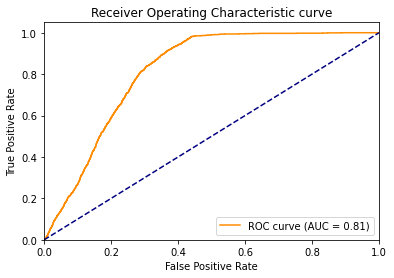

None


,Variable,Coefficient
0,Age,-0.034041
1,Annual_Premium,-0.000005
2,Vintage,-0.000818
3,Gender_Female,-0.389818
4,Gender_Male,-0.086894
5,Region_Code_3,-0.062447
6,Region_Code_8,-0.140828
7,Region_Code_11,-0.039531
8,Region_Code_15,-0.136776
9,Region_Code_28,0.397492


In [119]:
LR(train_data)

Best Parameters for Decision Tree:  {'max_depth': 4, 'min_samples_leaf': 1}
AUC Score for Decision Tree: 0.8293609723203235


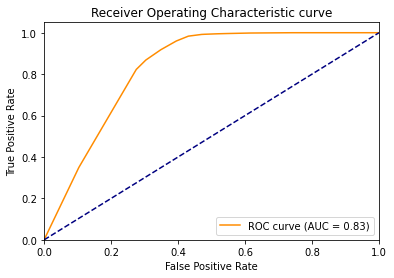

None


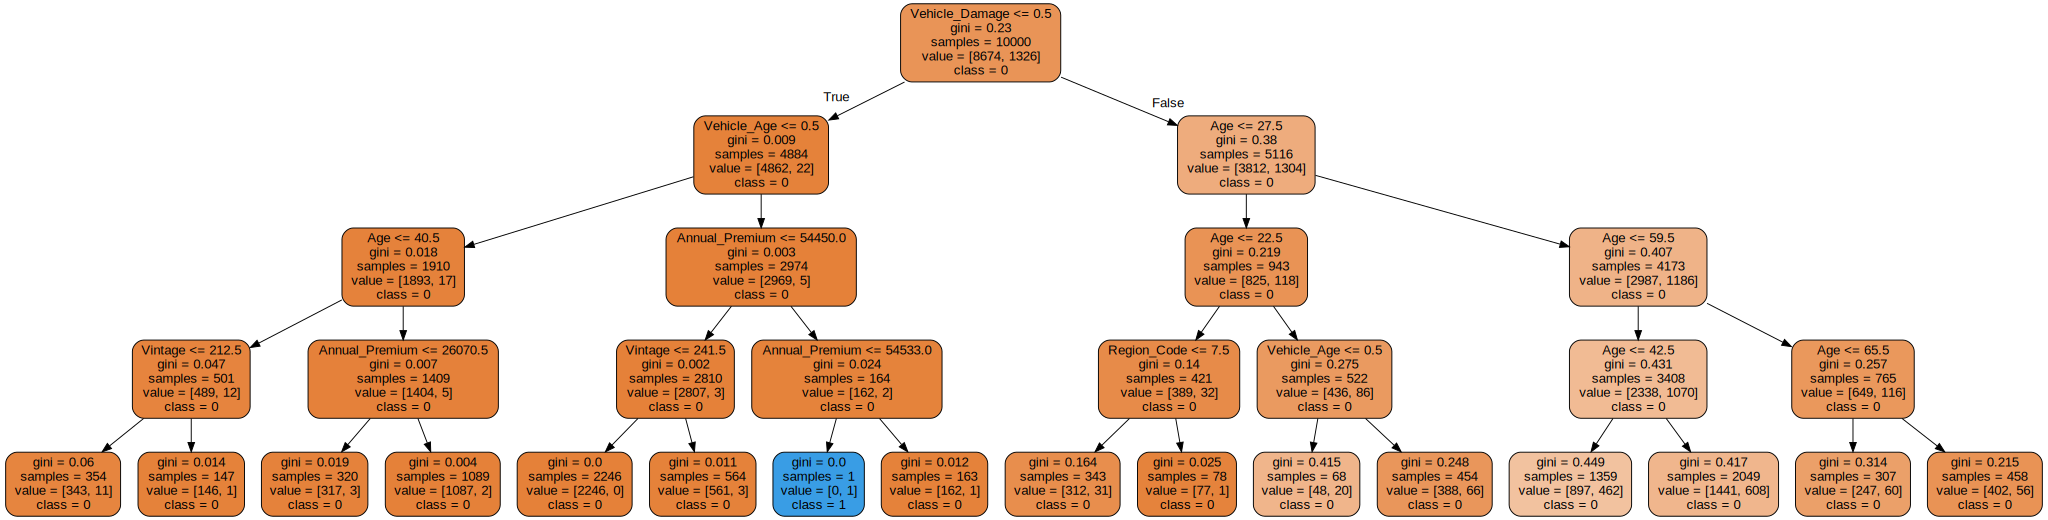

In [122]:
DT(train_data)

Best Parameters for Random Forest:  {'max_depth': 9, 'min_samples_leaf': 5}
AUC Score for Random Forest: 0.908346131414734


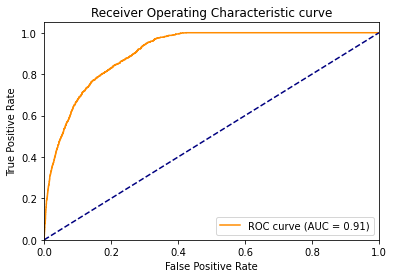

None


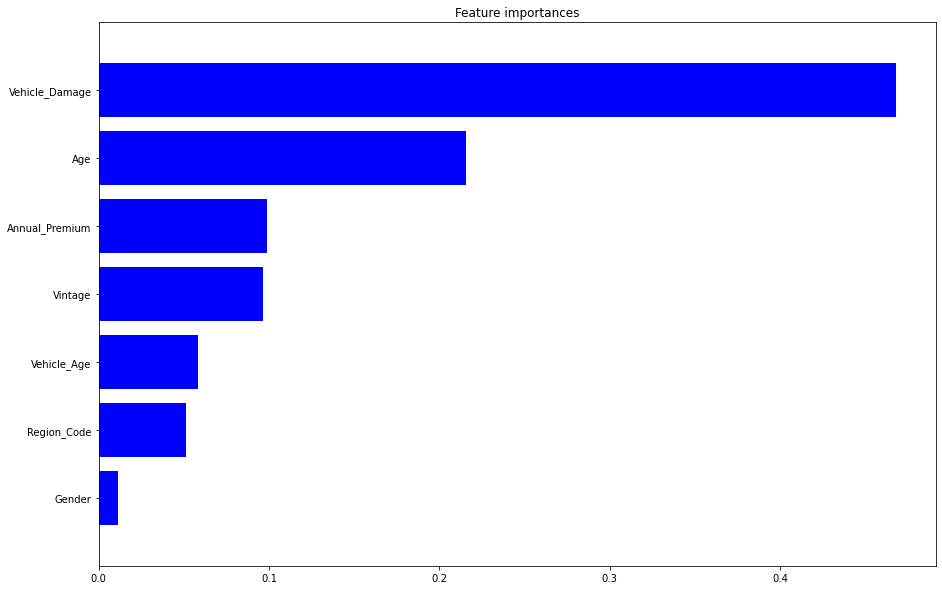

In [129]:
RF(train_data)

In [123]:
##Train vs Test
def DT_test(data_train,data_test):

    X_train,Y_train = clean_data_IE(data_train)
    X_test,Y_test = clean_data_IE(data_test)

    dt = DecisionTreeClassifier()
    param_dt = {'max_depth': [i for i in range(1,21,1)], 'min_samples_leaf': [1,2,3,4,5]}

    dt_clf = GridSearchCV(estimator=dt,
                         param_grid=param_dt,
                         scoring='roc_auc',
                         n_jobs =-1,
                          verbose = 0,
                         refit=True,
                         cv=5,
                         return_train_score=True)

    dt_result = dt_clf.fit(X_train,Y_train)

    best_params = dt_result.best_params_    
    print('Best Parameters from train for Decision Tree: ', best_params)
    
    predictions_proba_train = dt_clf.best_estimator_.predict_proba(X_train)[:,1]
    auc_train = roc_auc_score(Y_train,predictions_proba_train)
    print( "Train AUC Score for train Decision Tree:", auc_train)
    
    predictions_proba_test = dt_clf.best_estimator_.predict_proba(X_test)[:,1]
    auc_test = roc_auc_score(Y_test,predictions_proba_test)
    print( "Test AUC Score for test Decision Tree:", auc_test)

    fpr, tpr, thresholds = roc_curve(Y_test,predictions_proba_test)
    print(ROCgraph(fpr,tpr))
    

    return auc_test, predictions_proba_test, Y_test


Best Parameters from train for Decision Tree:  {'max_depth': 4, 'min_samples_leaf': 1}
Train AUC Score for train Decision Tree: 0.8293609723203235
Test AUC Score for test Decision Tree: 0.821802938391973


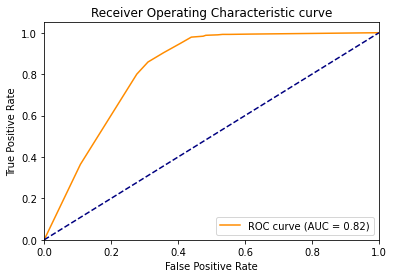

None


(0.821802938391973,
 array([0.14537445, 0.29411765, 0.29673011, ..., 0.03107345, 0.33995585,
        0.12227074]),
 0       0
 1       0
 2       0
 3       0
 4       1
        ..
 9995    0
 9996    1
 9997    0
 9998    0
 9999    1
 Name: Response, Length: 10000, dtype: int64)

In [124]:
DT_test(train_data,test_data)

Best Parameters from train for Decision Tree:  {'max_depth': 4, 'min_samples_leaf': 1}
Train AUC Score for train Decision Tree: 0.8293609723203235
Test AUC Score for test Decision Tree: 0.821802938391973


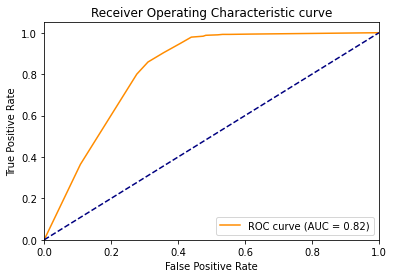

None
Confusion Matrix at 1%: 
 [[4468 4168]
 [  17 1347]]
Confusion Matrix at 10%: 
 [[5115 3521]
 [  69 1295]]
Confusion Matrix at 20%: 
 [[6219 2417]
 [ 265 1099]]
Confusion Matrix at 50%: 
 [[8636    0]
 [1364    0]]


In [125]:
##Test set with confusion matrix
blank,prob,y = DT_test(train_data,test_data)

con = confusion_mat(prob,y)

In [126]:
benefit_st_old(con)

Benefit Structure at 0.01: -551
Benefit Structure at 0.1: 402
Benefit Structure at 0.2: -10
Benefit Structure at 0.5: -13640
The best probability threshold is at 0.1


In [127]:
benefit_st_new(con)

Benefit Structure at 0.01: 119149
Benefit Structure at 0.1: 110742
Benefit Structure at 0.2: 75050
Benefit Structure at 0.5: -136400
The best probability threshold is at 0.01


In [115]:
#LR + Lasso or Ridge
def LR_l1_l2(data):

    X,Y = clean_data_OHE(data)

    lr = LogisticRegression(solver='liblinear')
    param_lr = {'C':[0.001, 0.01, 0.05, 0.1, 1, 100], 'penalty': ['l1','l2'], 'max_iter': np.arange(50,100,1)}

    lr_clf = GridSearchCV(estimator=lr,
                         param_grid=param_lr,
                         scoring='roc_auc',
                         n_jobs =-1,
                          verbose = 0,
                         refit=True,
                         cv=5,
                         return_train_score=True)

    lr_result = lr_clf.fit(X,Y)

    best_params = lr_result.best_params_    
    print('Best Parameters for Logistic Regression: ', best_params)
    
    predictions_proba = lr_clf.best_estimator_.predict_proba(X)[:,1]
    auc = roc_auc_score(Y,predictions_proba)
    print( "AUC Score for Logistic Regression:", auc)

    fpr, tpr, thresholds = roc_curve(Y,predictions_proba)
    print(ROCgraph(fpr,tpr))
    
    coef = lr_clf.best_estimator_.coef_[0]
    col = list(X.columns)
    coefficient_df = pd.DataFrame({"Variable" : col, "Coefficient": coef})
    return coefficient_df   


Best Parameters for Logistic Regression:  {'C': 1, 'max_iter': 87, 'penalty': 'l1'}
AUC Score for Logistic Regression: 0.8216577793033463


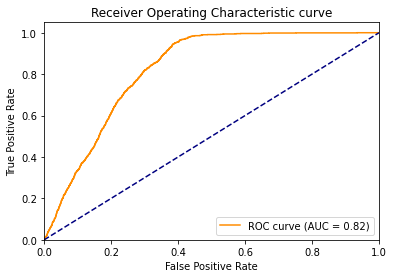

None


,Variable,Coefficient
0,Age,-2.109202e-02
1,Annual_Premium,-2.451501e-08
2,Vintage,-5.386413e-05
3,Gender_Female,-8.274931e-01
4,Gender_Male,-7.479758e-01
5,Region_Code_3,0.000000e+00
6,Region_Code_8,-1.717125e-01
7,Region_Code_11,4.639843e-01
8,Region_Code_15,-5.642197e-01
9,Region_Code_28,6.865165e-02


In [116]:
LR_l1_l2(train_data)

In [117]:
def LR_test(data_train,data_test):

    X_train,Y_train = clean_data_OHE(data_train)
    X_test,Y_test = clean_data_OHE(data_test)

    lr = LogisticRegression()
    param_lr = {'C':[0.001, 0.01, 0.05, 0.1, 1, 100], 'penalty': ['l1','l2'], 'max_iter': np.arange(50,100,1)}

    lr_clf = GridSearchCV(estimator=lr,
                         param_grid=param_lr,
                         scoring='roc_auc',
                         n_jobs =-1,
                          verbose = 0,
                         refit=True,
                         cv=5,
                         return_train_score=True)

    lr_result = lr_clf.fit(X_train,Y_train)

    best_params = lr_result.best_params_    
    print('Best Parameters from train for Logistic Regression: ', best_params)
    
    predictions_proba_train = lr_clf.best_estimator_.predict_proba(X_train)[:,1]
    auc_train = roc_auc_score(Y_train,predictions_proba_train)
    print( "Train AUC Score for Logistic Regression:", auc_train)
    
    predictions_proba_test = lr_clf.best_estimator_.predict_proba(X_test)[:,1]
    auc_test = roc_auc_score(Y_test,predictions_proba_test)
    print( "Test AUC Score for Logistic Regression:", auc_test)

    fpr, tpr, thresholds = roc_curve(Y_test,predictions_proba_test)
    print(ROCgraph(fpr,tpr))
    
    
    return auc_test, predictions_proba_test, Y_test

Best Parameters from train for Logistic Regression:  {'C': 0.05, 'max_iter': 74, 'penalty': 'l2'}
Train AUC Score for Logistic Regression: 0.8140093606836679
Test AUC Score for Logistic Regression: 0.8149003981831493


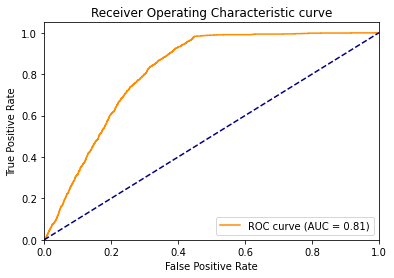

None


(0.8149003981831493,
 array([0.18165426, 0.5258064 , 0.3364048 , ..., 0.04808376, 0.30747907,
        0.15166289]),
 0       0
 1       0
 2       0
 3       0
 4       1
        ..
 9995    0
 9996    1
 9997    0
 9998    0
 9999    1
 Name: Response, Length: 10000, dtype: int64)

In [118]:
LR_test(train_data,test_data)